In [2]:
%ls

BenJackCode/            hmmbase.py              pybasicbayes/
README.md               hmmbatchcd.py           setup.py
VI-sandbox/             hmmbatchsgd.py          sgd_tests.ipynb
__pycache__/            hmmsgd_metaobs.py       test_hmmbatchcd.py
build/                  hsmmbase.py             test_hmmbatchsgd.py
change_notes.txt        hsmmbatchcd.py          test_hmmsgd_metaobs.py
experiments.ipynb       hsmmbatchsgd.py         test_hsmmbatchcd.py
fdr.pyx                 legendhmm.png           test_hsmmbatchsgd.py
generate_data.py        matrix_expansion.py     util.py
hmm_fast.pyx            munkres.py              what_do_hsmm.ipynb


In [3]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


We do 3 approximation tests using "test_hmmbatchsgd.py" and "test_hmmbatchscd.py".

## SGD

[-1.16565277  5.44588484]
Hamming Distance =  0.2996666666666667


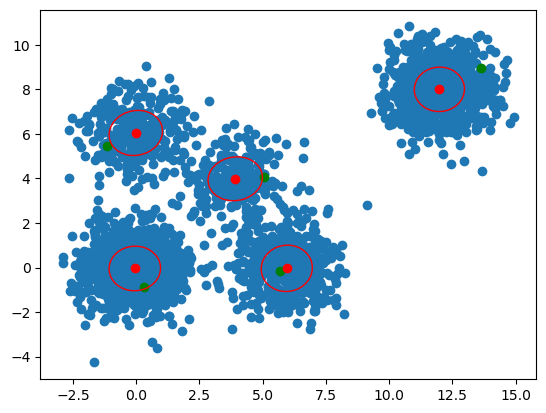

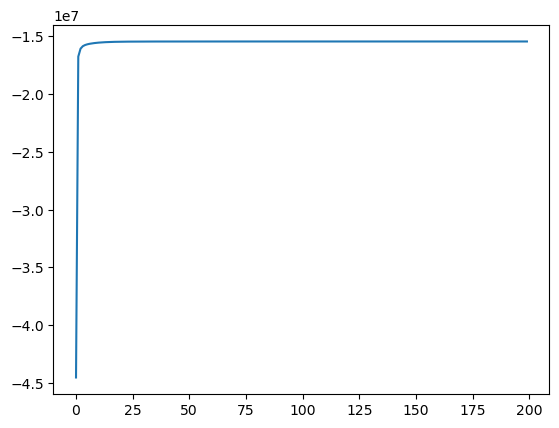

In [4]:
for i in range(1):
    test_hmmbatchsgd()

## CD

True
terminated early - convergence, 
 elbo : -15473068.700407032 
 lower bound : -15473068.700407032
allclose  = True, diff : 0.0
[-0.15783967  5.99853343]
Hamming Distance =  0.377


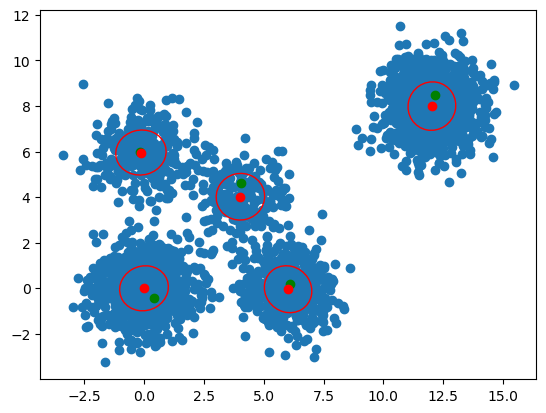

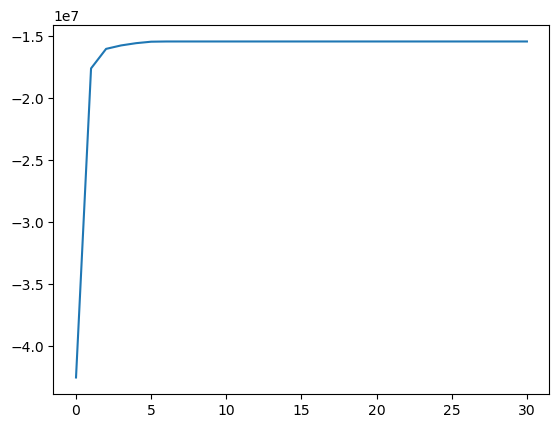

True
terminated early - convergence, 
 elbo : -15375741.267469842 
 lower bound : -15375741.267469842
allclose  = True, diff : 0.0
[12.76776158  8.14080796]
Hamming Distance =  0.3433333333333333


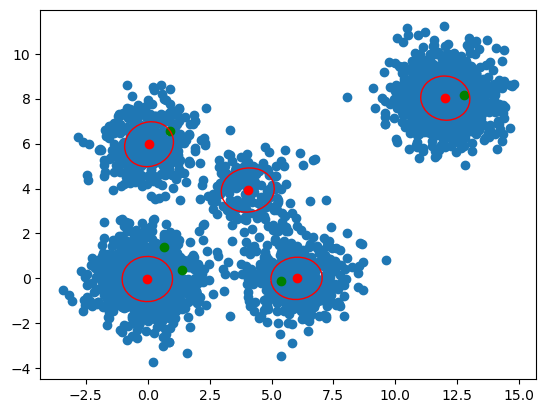

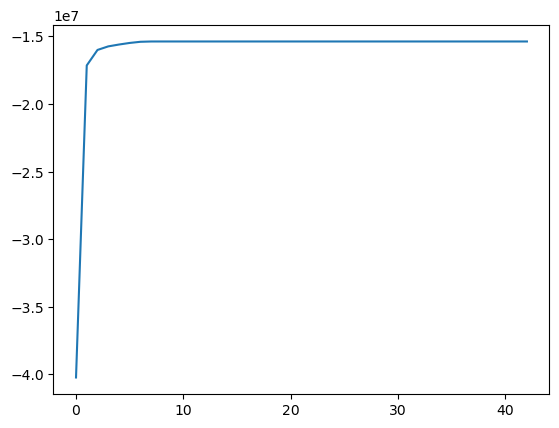

True
terminated early - convergence, 
 elbo : -15662009.034784377 
 lower bound : -15662009.034784377
allclose  = True, diff : 0.0
[13.5168043   8.58514643]
Hamming Distance =  0.337


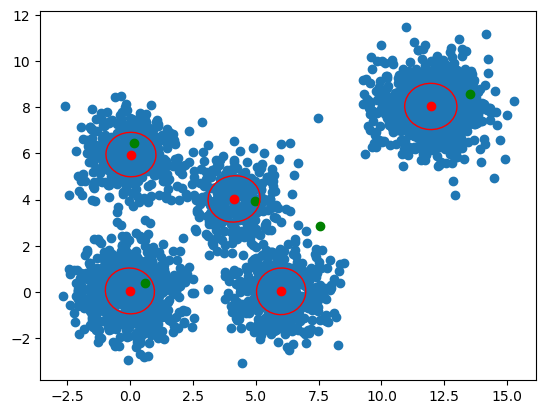

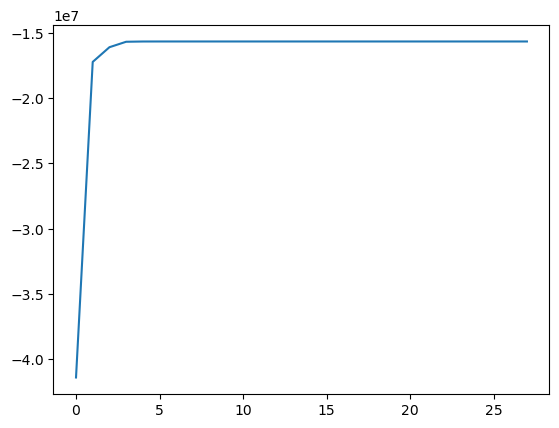

In [5]:
for i in range(3):
    test_hmmbatchcd()

### Interactive testing with comparision

ToDO  - finish this section

In [6]:
import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *
from sklearn.cluster import KMeans


In [7]:
centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])
# T = np.array([[0.8,0.2],[0.3,0.7]])

N = 3000

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)

kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_

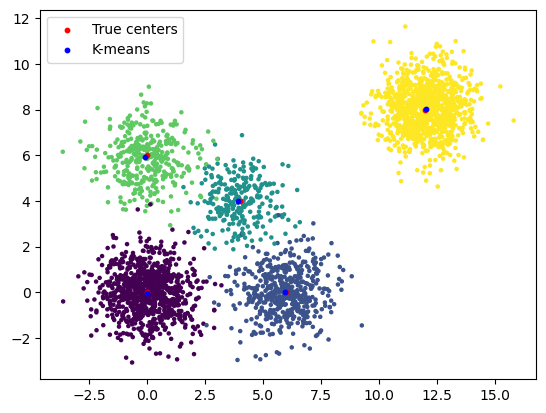

In [8]:
plt.scatter(obs[:,0],obs[:,1],  s=5, c =seq)
plt.scatter(centers[:,0],centers[:,1], s=10, c='red',label = 'True centers')
plt.scatter(mu_0[:,0],mu_0[:,1], s=10, c='blue', label = 'K-means')
plt.legend()
plt.show()

[5.67024119 5.14027761]
True
terminated early - convergence, 
 elbo : -15548923.945406754 
 lower bound : -15548923.945406754
allclose  = True, diff : 0.0
[5.67024119 5.14027761]
Hamming Distance =  0.321


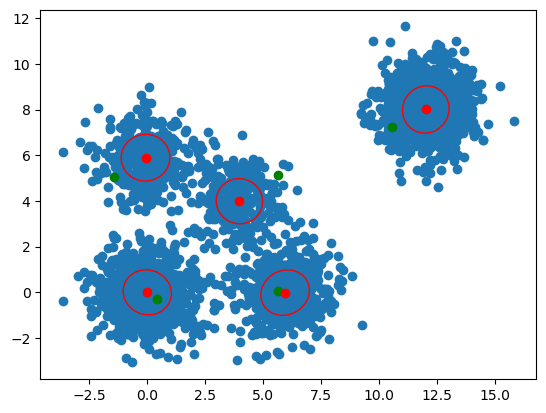

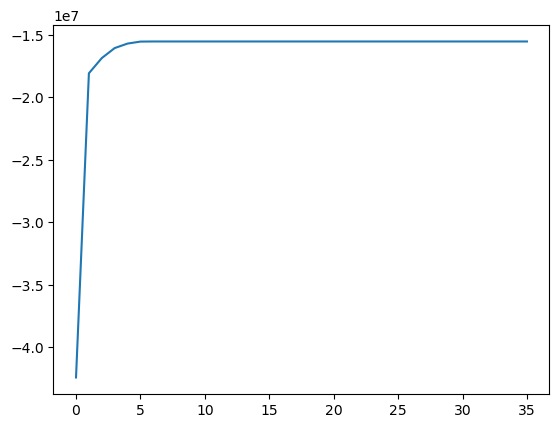

time is:  2.872472047805786


In [9]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM
import seaborn as sns
from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *
from sklearn.cluster import KMeans
import time 


kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)

kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4


# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=1000, epsilon=10**(-12))  
start_time = time.time()
hmm.infer() # do inference 
end_time = time.time()
sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()
elapsed_time_VB = end_time - start_time 
print('time is: ',elapsed_time_VB)

In [39]:
np.arange(1,4+1)*2 + 2

array([ 4,  6,  8, 10])

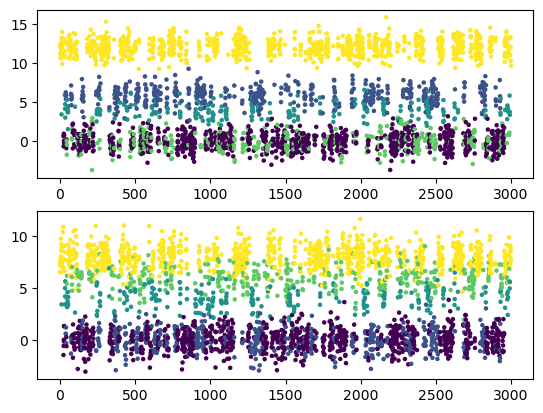

In [10]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs[:,0],s=5, c =seq )
axs[1].scatter([i for i in range(N)],obs[:,1],s=5, c =seq )

In [11]:
centers , T

(array([[ 0,  0],
        [ 6,  0],
        [ 4,  4],
        [ 0,  6],
        [12,  8]]),
 array([[0.89 , 0.01 , 0.01 , 0.05 , 0.04 ],
        [0.05 , 0.8  , 0.05 , 0.05 , 0.05 ],
        [0.05 , 0.1  , 0.7  , 0.05 , 0.1  ],
        [0.1  , 0.1  , 0.05 , 0.7  , 0.05 ],
        [0.025, 0.025, 0.025, 0.025, 0.9  ]]))

## Jack's and Ben's code from stan analysis

In [12]:
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()
mu_0_ = KMeans(init="random",n_clusters=1,n_init=10,max_iter=300,random_state=42).fit(obs).cluster_centers_[0]
dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":D, "K":K, 'mu_0':mu_0_ , 'kappa_0':kappa_0/5, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,K))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
start_time = time.time()
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 2000 )
end_time = time.time()

elapsed_time_MCMC = end_time - start_time 

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Ins

In [31]:
print(elapsed_time_MCMC)

975.3077349662781


In [32]:
# for every state extract parameters into a dict 
from scipy.stats import invwishart,t,beta

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]



VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_tran[i][j]

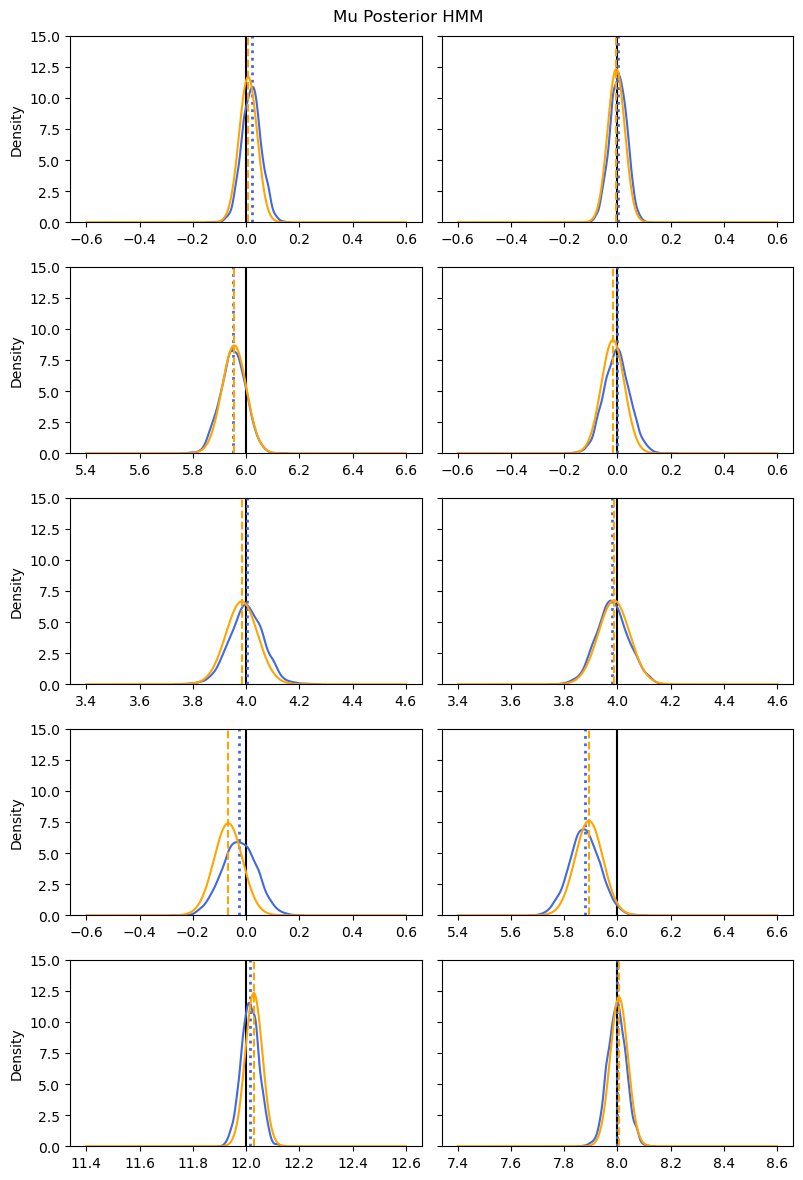

In [34]:
K=5
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)
D=2
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0,20,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')
        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI mean',linestyles='dashed')


        plt.ylim((0,15))
plt.suptitle('Mu Posterior HMM')
plt.ylabel('State i')
# legend = plt.legend(fontsize = 8)
plt.tight_layout()



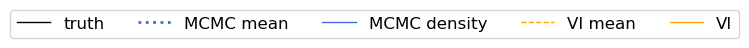

In [35]:
fig_legend, ax_legend = plt.subplots(figsize=(6, 0.5))
ax_legend.axis('off')

# Create a legend for the desired elements
legend_elements = [
    plt.Line2D([0], [0], color='black', linewidth=1, label='truth'),
    plt.Line2D([0], [0], color='royalblue', linewidth=2, linestyle='dotted', label='MCMC mean'),
    plt.Line2D([0], [0], color='royalblue', linewidth=1, label='MCMC density'),
    plt.Line2D([0], [0], color='orange', linewidth=1, label='VI mean', linestyle='dashed'),
    plt.Line2D([0], [0], color='orange', linewidth=1, label='VI'),
]

# Plot the legend
ax_legend.legend(handles=legend_elements, loc='center', fontsize=12, ncol=5)
plt.tight_layout()
plt.show()

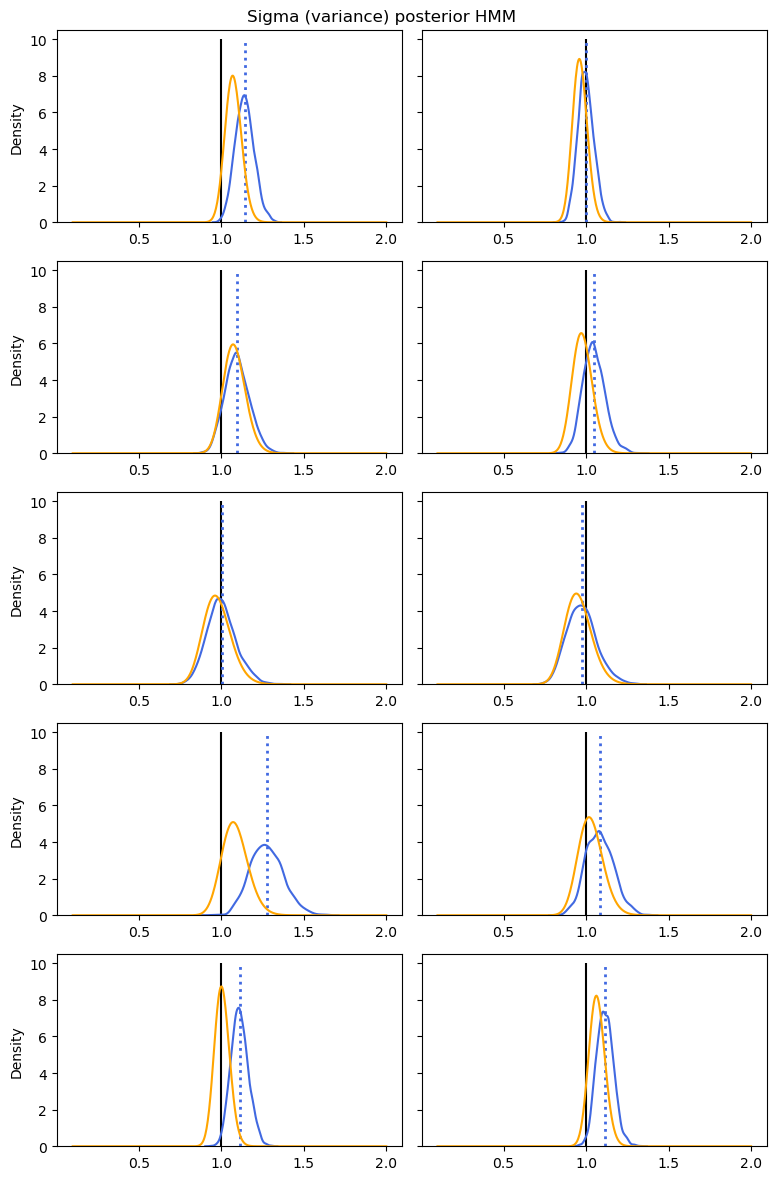

In [36]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')


        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigma (variance) posterior HMM')
# plt.legend(fontsize = 8)
plt.tight_layout()

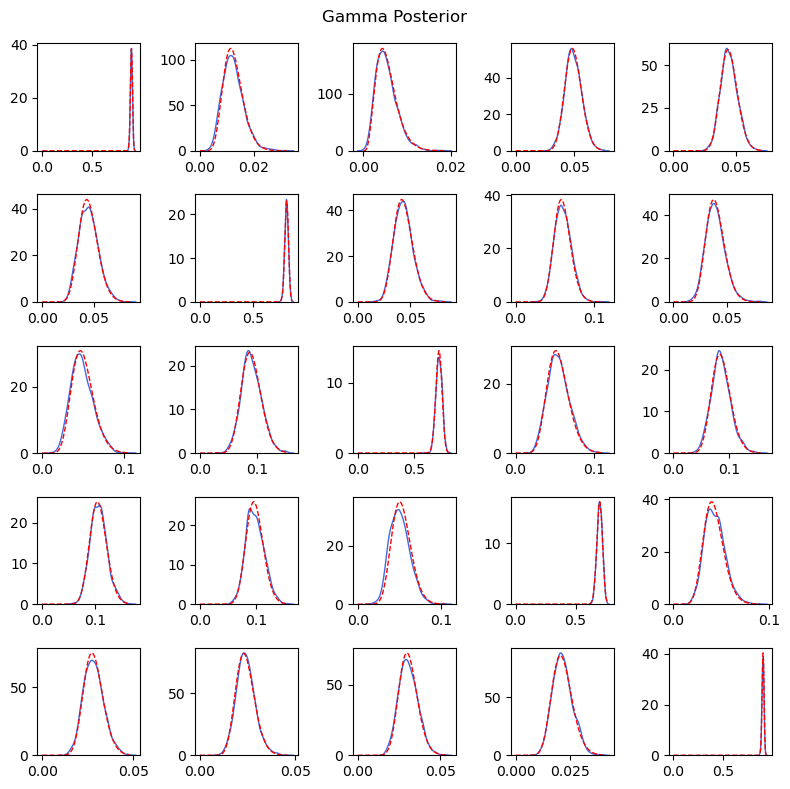

In [37]:
K=5
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        ax = axs[k,j]
        sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0, color = 'royalblue')
        x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)
        dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist,label = 'VI beta',color = 'red',linewidth=1.0,linestyle = 'dashed')
        # ax.vlines(T[k][j],0,60,color = 'red',label='truth',linewidth=1.0,linestyle = 'dotted')

        # ax.set_xlim(0,1)
        ax.set(ylabel=None)


plt.suptitle('Gamma Posterior')
# plt.legend(fontsize = 8)
plt.tight_layout()

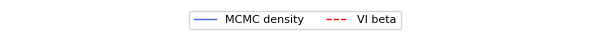

In [19]:
fig_legend, ax_legend = plt.subplots(figsize=(6, 0.5))
ax_legend.axis('off')

# Create a legend for the desired elements
legend_elements = [
    plt.Line2D([0], [0], color='royalblue', linewidth=1.0, label='MCMC density'),
    plt.Line2D([0], [0], color='red', linewidth=1.0, linestyle='dashed', label='VI beta'),
]

# Plot the legend
ax_legend.legend(handles=legend_elements, loc='center', fontsize=8,ncol=2)
plt.tight_layout()
plt.show()

# HSMM

In [20]:
# generate dtaa for hsmm with fixed dwell time parameter
# 3 states 
from scipy.stats import poisson
import matplotlib.pyplot as plt
import numpy as np
from pybasicbayes.distributions import Gaussian 

def generate_states_pois(T: np.array,lambda_js: list , n_obs: int):

    states = [i for i in range(1,T.shape[0]+1)]
    # sample first beginning state
    state_seq = [np.random.randint(1,states[-1]+1)]
    end_of_dwell = False
    while True:
        # sample dwell time in last state 
        if end_of_dwell == False:
            d = poisson.rvs(lambda_js[state_seq[-1]-1])
        else:
            d=1
        state_seq = state_seq + [state_seq[-1]]*(d-1)
        state_seq.append(np.random.choice(states,p=T[state_seq[-1]-1]))
        end_of_dwell = False
        if state_seq[-1] == state_seq[-2]:
            end_of_dwell = True


        if len(state_seq) >= n_obs : 
            state_seq = state_seq[:n_obs]
            break
    
    ind_for_state_j = [np.where(np.asarray(state_seq)==j) for j in states]

    return np.asarray(state_seq,dtype=int), ind_for_state_j

def generate_data(emit : np.array, ind_for_state_j: np.array):
    obs = np.zeros((sum([len(j[0]) for j in ind_for_state_j]),emit[0].mu.shape[0]))
    for states in range(len(ind_for_state_j)):
        obs[ind_for_state_j[states]] = emit[states].rvs(size = len(ind_for_state_j[states][0]))
    return obs

def make_emissions(centers: list , kappa_0: float, nu_0:float,sigmas = [np.eye(2)]):
    emits = []
    if len(sigmas) == 1:
        sigmas = [np.eye(len(centers[0]))]*len(centers)
    elif len(sigmas)!= len(centers):
        raise ValueError('Wrong covariance matrix dimension')
    for i in range(len(centers)):
        emits.append(Gaussian(mu=np.array(centers[i]),
                    sigma=sigmas[i],
                    mu_0=np.zeros(len(centers[i])),
                    sigma_0=np.eye(len(centers)),
                    kappa_0=kappa_0,
                    nu_0=nu_0))
    return np.array(emits)

def relabel_seq(seq_lab, a_js):
    pos = 1
    new_lab = seq_lab.copy()
    for i in range(1,sum(a_js)+1):
        # if i <= sum(a_js[:pos]):
        new_lab[new_lab == i] = pos
        if i == sum(a_js[:pos]):
            pos+=1
    return new_lab

In [21]:
centers = [np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])]
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 3           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

# T = np.array([
#     [0.89,0.01,0.01,0.05,0.04],
#     [0.05,0.8,0.05,0.05,0.05],
#     [0.05,0.1,0.7,0.05,0.1],
#     [0.1,0.1,0.05,0.7,0.05],
#     [0.025,0.025,0.025,0.025,0.9]
#     ])
# T = np.array([[0.8,0.2],[0.3,0.7]])
T = np.array([[0,0.6,0.4],
              [0.45,0,0.55],
              [0.9,0.1,0]
              ])

lambda_js = [5,4,3]

N = 3000

emit_hsmm = make_emissions(centers , kappa_0, nu_0)


seq_hsmm, ind_hsmm = generate_states_pois(T,lambda_js,N)

obs_hsmm = generate_data(emit_hsmm,ind_hsmm)

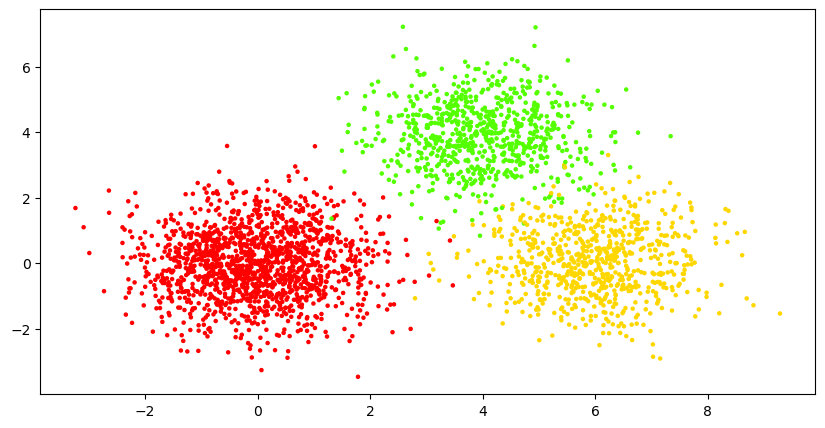

In [22]:
plt.figure(figsize = (10,5))
plt.scatter(obs_hsmm[:,0],obs_hsmm[:,1],  s=5, c =seq_hsmm ,cmap = 'prism')
plt.show()

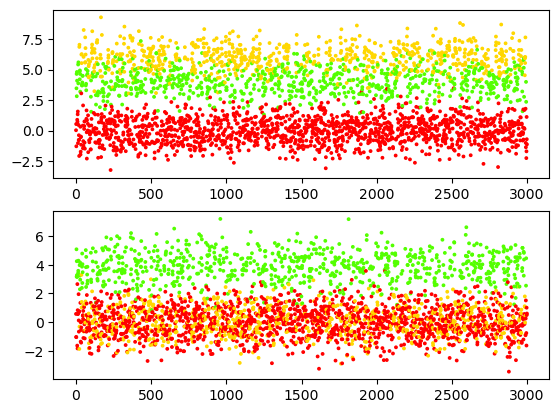

In [23]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm ,cmap = 'prism')
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm ,cmap = 'prism')


In [24]:
from matrix_expansion import expand_matrix
a_js = [7,6,5]
T_HMM = expand_matrix(T, lambda_js , a_js)
T_HMM.shape

(18, 18)

In [25]:
centers_hmm = []
for i in range(len(a_js)):
    centers_hmm = centers_hmm + [centers[i]]*a_js[i]
    
emit_hmm = make_emissions(centers_hmm , kappa_0, nu_0)
seq_hmm, ind_hmm = generate_states(T_HMM,N)

obs_hmm = generate_data(emit_hmm,ind_hmm)

new_seq_hmm = relabel_seq(seq_hmm,a_js)

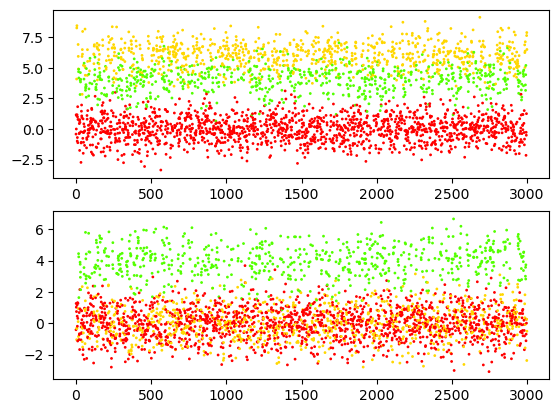

In [26]:
fig, axs = plt.subplots(2, 1)

# axs[0].scatter([i for i in range(N)],obs_hmm[:,0],s=15, c =seq_hmm ,cmap = 'plasma')
axs[0].scatter([i for i in range(N)],obs_hmm[:,0],s=1, c =np.array(new_seq_hmm) ,cmap = 'prism')

# axs[1].scatter([i for i in range(N)],obs_hmm[:,1],s=15, c =seq_hmm ,cmap = 'plasma')
axs[1].scatter([i for i in range(N)],obs_hmm[:,1],s=1, c =np.array(new_seq_hmm) ,cmap = 'prism')

# Matrix Expansion 

In [27]:
from matrix_expansion import *
test_matrix_expansion()

This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()
The HSMM matrix is :
[[0.  0.8 0.2]
 [0.3 0.  0.7]
 [0.5 0.5 0. ]]
a_js are: [2 2 2]
lambda_js are: [1 2 3]
sum of row entries :[1. 1. 1. 1. 1. 1.]
[[0.         0.41802329 0.46558137 0.         0.11639534 0.        ]
 [0.         0.3038944  0.55688448 0.         0.13922112 0.        ]
 [0.09391059 0.         0.         0.68696471 0.2191247  0.        ]
 [0.13670365 0.         0.         0.54432116 0.31897519 0.        ]
 [0.07859354 0.         0.07859354 0.         0.         0.84281291]
 [0.13987721 0.         0.13987721 0.         0.         0.72024558]]


## CD vs GD

Time comparison for N=30000 observations

TO-DO:
    
    - there's something going on with max_iterations, even if N is higher it does not affect the exec time
    
    - cd and sgd  use maxit 100000

In [28]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

[9.84835692 6.68155179]
Hamming Distance =  0.37433333333333335


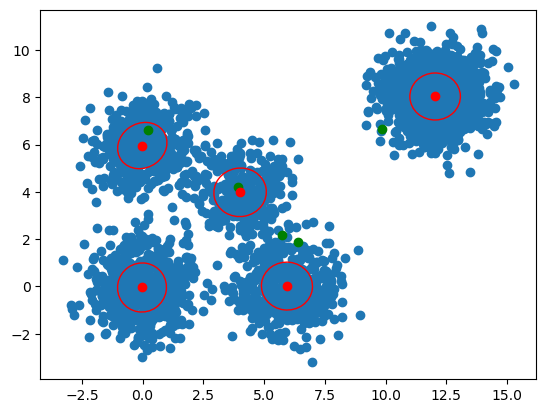

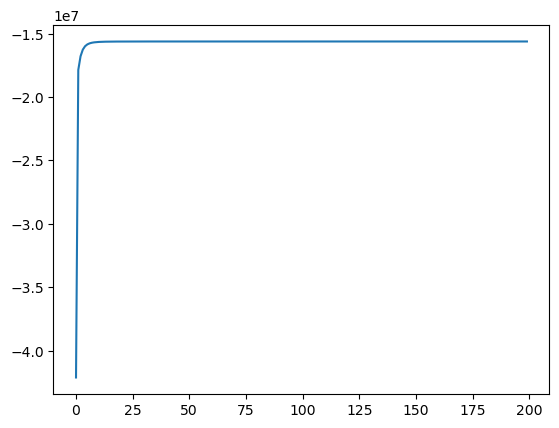

True
terminated early - convergence, 
 elbo : -15485457.464603573 
 lower bound : -15485457.464603573
allclose  = True, diff : 0.0
[6.11057364 0.15860333]
Hamming Distance =  0.354


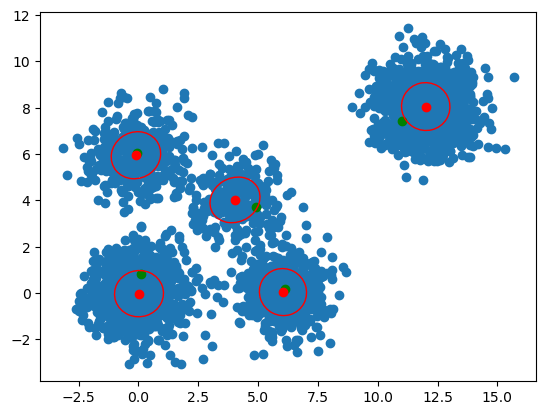

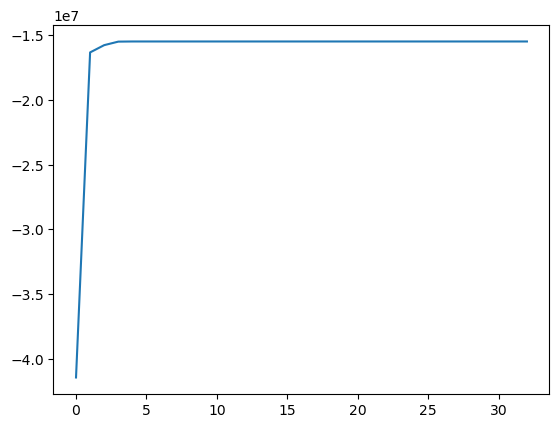

In [29]:
import time

# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd()
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time


In [30]:
print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

test_hmmbatchsgd() took 12.77 seconds to run
test_hmmbatchcd() took 2.70 seconds to run
